### Load Libraries

In [30]:
import sys
import os

# Add the directory of the .py file to the path (only needed once at top)
sys.path.append(os.getcwd())
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [31]:
import importlib
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
import cv2
import torch
from matplotlib import pyplot as plt
import json
from tqdm import tqdm
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from IPython.display import display
import ipywidgets as widgets
import ipyevents
from PIL import Image
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
from pathlib import Path
import labelling_functions


In [3]:
## Run this cell to reload functions from labelling_functions.py after editing --------------
importlib.reload(labelling_functions)
import labelling_functions

### Set File Paths

Choose a video to label from the RiverWatcher folder. Check the excel sheet for the species ID. Watch the mp4 video and make note of whether the fish leaves the frame and reappears. If it does, flag this video! Also make note of whether the fish is in the frame at the end of the video. If it is not, then we do not need to propagate masks through the whole video.

The video_dir should be set to the video location. The rest of the folders and files we create will have a standard naming structure based on te name of the video file path and eerythig will be saved in Fishway_Data/.

In [3]:
## Create a new folder named after the video path to store the images and annotations -------------

video_dir = "/Users/simone/Documents/UofT MSc/LOMU_Fishway_Data/RiverWatcher/test/Ganaraska/08162024-08202024/24  08  16  13  29/190.mp4" # Change this to your chosen video path
video_path = Path(video_dir)

# Extract parts from the path
parts = video_path.parts[-4:-1]  # ['Credit', '08012024-08122024', '24  08  01  11  58']
filename_stem = video_path.stem  # '28'

# Construct new folder name
new_folder_name = "__".join(parts + (filename_stem,))

new_base_dir = Path("/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data") # Change this to the directory you will store the images and annotations for all videos

# Full path to new folder
new_folder_path = new_base_dir / new_folder_name

# Create the directory (if it doesn't already exist)
new_folder_path.mkdir(parents=True, exist_ok=True)

print(f"Created folder: {new_folder_path}")


Created folder: /Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Ganaraska__08162024-08202024__24  08  16  13  29__190


In [4]:
## Extract frames from the video and save them to the new folder -----------------------------
# New folder to store images
images_path = new_folder_path / "images"
# Extract frames
labelling_functions.extract_frames_ffmpeg(video_path, images_path)

Running command: ffmpeg -i /Users/simone/Documents/UofT MSc/LOMU_Fishway_Data/RiverWatcher/test/Ganaraska/08162024-08202024/24  08  16  13  29/190.mp4 -q:v 2 -vsync vfr -start_number 0 /Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Ganaraska__08162024-08202024__24  08  16  13  29__190/images/%05d.jpg


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Frames saved to: /Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Ganaraska__08162024-08202024__24  08  16  13  29__190/images


[out#0/image2 @ 0x11f038590] video:11486KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: unknown
frame=  162 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.50 bitrate=N/A speed=76.2x    


The cell below will create a coco json file which create a dictionary for all the images. The annotations section of the json will be blank and will be filled up when we generate the masks.

In [5]:
## Create COCO JSON to store annotations -----------------------------
# New folder to store annotations
annotations_path = new_folder_path / "annotations"
annotations_path = Path(annotations_path)
annotations_path.mkdir(parents=True, exist_ok=True)
# Path to save the JSON file
json_path = annotations_path / "instances_default.json"
# Create COCO JSON
coco = labelling_functions.create_coco_json(images_path, json_path)

# Map image_id to image metadata
image_id_to_data = {img["id"]: img for img in coco["images"]}

annotations_by_image = {}
for ann in coco["annotations"]:
    annotations_by_image.setdefault(ann["image_id"], []).append(ann)

category_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}
category_name_to_id = {cat["name"]: cat["id"] for cat in coco["categories"]}
categories = list(category_id_to_name.values())

COCO JSON Saved


### Set Up SAM2 For Inference

The code in this section sets up the model for running inference on the chosen video. The jpeg frames are added to the inference state and this inference state is used and continuously updated when generating or propagating masks. 

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
elif device.type == "cpu":
    torch.autocast("cpu", dtype=torch.bfloat16).__enter__()

#torch.set_float32_matmul_precision('high')

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [7]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/checkpoints/sam2.1_hiera_large.pt" # Change this to the path of your SAM2 checkpoint (see README for details)
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [8]:
# Load the video and initialize the predictor... create inference state
inference_state = predictor.init_state(video_path=str(images_path))

frame loading (JPEG): 100%|██████████| 162/162 [00:04<00:00, 36.52it/s]


### Create Initial Mask for Propagation

If you ever want to reset the inference state to start over labelling the video then you can run the cel bellow.

In [ ]:
#predictor.reset_state(inference_state)

This widget allows you to add positive and negative clicks to indicate where fish are. You can select the species from the dropdown menu and if there are more than one fish of the same species in the frame you can select the object number (make sure to keep the object number consistent between frames). If there is not more than one fish of the same species in the frame then the objet umber will automatically be 1 for ech speacies so you do not need to do anything. A left click will give a positive click and a right click will give a negative click (meaning that the object is not in the clicked location).



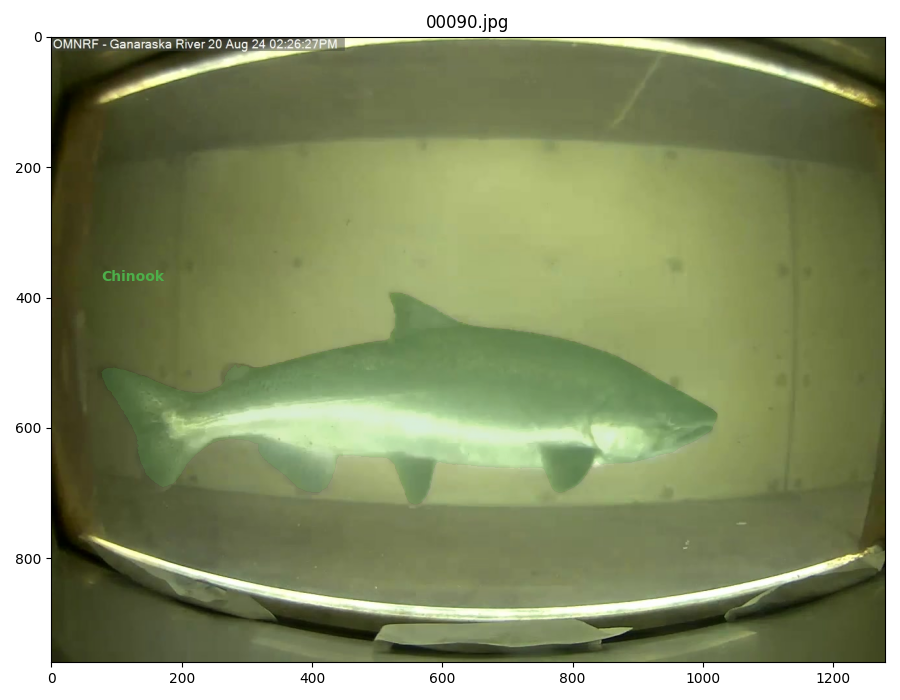

In [29]:
%matplotlib widget
from labelling_functions import ImageAnnotationWidget

# Initialize widget
widget = ImageAnnotationWidget(
    coco_dict=coco,
    image_dir=images_path,
    image_id_to_data=image_id_to_data,
    start_frame=90
)

After creating some point clicks to indicate fish in the first few frames we can predict masks on each of those frames individually. First, we will clean up the click dictionary to remove any empty entries and create two dictionaries which will help us keep track of which fish is which and allow us to update the coco annotations properly.

In [13]:
# Remove any empty clicks
clicks = labelling_functions.clean_clicks(widget.clicks)

# Create dictionary for trackIDs if not already created
if "clickID_to_trackID" not in locals():
    clickID_to_trackID = {}
    track_id = 1
# Create a mapping from clickID (Species, ObjectNum) to trackID
for frame_data in clicks.values():
    for category, objects in frame_data.items():
        for obj_id in objects:
            key = (category, obj_id)
            if key not in clickID_to_trackID:
                clickID_to_trackID[key] = track_id
                track_id += 1
                
# Create a mapping from trackID to category
trackID_to_category = {v: k[0] for k, v in clickID_to_trackID.items()}

# Create a mapping from (image_id, trackID) to annotation list index
ann_index_map = {}
for idx, ann in enumerate(coco.get("annotations", [])):
    key = (ann["image_id"], ann["attributes"]["track_id"])
    ann_index_map[key] = idx
clicks

{81: {'Chinook': {'1': {'pos': [[68, 419], [78, 459]], 'neg': []}}},
 82: {'Chinook': {'1': {'pos': [[70, 385], [130, 468], [75, 493]],
    'neg': [[30, 445]]}}},
 83: {'Chinook': {'1': {'pos': [[240, 445], [155, 364], [91, 496]],
    'neg': []}}},
 84: {'Chinook': {'1': {'pos': [[273, 450], [167, 373], [96, 474]],
    'neg': []}}},
 85: {'Chinook': {'1': {'pos': [[124, 350],
     [106, 553],
     [332, 474],
     [153, 468]],
    'neg': []}}},
 86: {'Chinook': {'1': {'pos': [[150, 564],
     [79, 477],
     [113, 434],
     [192, 342],
     [384, 587],
     [515, 447]],
    'neg': [[187, 570], [106, 521]]}}}}

Now we can use our click dictionary to prompt SAM2. We can add the clicks to the inference state and predict masks for each of the frames that have click prompts. The masks are automatically updated in the coco dictionary (they have not been saved to the json file yet tough) so you can go back and run the above widget to visualize the masks that are generated. 

In [14]:
# Add points as inputs for generating new masks on some frames
f_inds = list(clicks.keys())
updated_frames = []
for im_id in tqdm(f_inds):
    ann_frame_idx = im_id - 1
    fishes = list(clicks[im_id].keys())
    for fish in fishes:
        # Get the category ID
        category_id = category_name_to_id[fish]
        fish_ids = list(clicks[im_id][fish].keys())
        for fish_id in fish_ids:
            ann_obj_id = clickID_to_trackID[(fish, fish_id)]
        
            # Extract clicks for this image
            all_clicks = clicks[im_id][fish][fish_id]
            if len(all_clicks["pos"]) > 0:
                pos_points = np.array(all_clicks["pos"], dtype=np.float32)
                pos_labels = np.array([1] * len(pos_points), dtype=np.int32)
                points = pos_points
                labels = pos_labels
                if len(all_clicks["neg"]) > 0:
                    neg_points = np.array(all_clicks["neg"], dtype=np.float32)
                    neg_labels = np.array([0] * len(neg_points), dtype=np.int32)
                    points = np.concatenate((pos_points, neg_points), axis=0)
                    labels = np.concatenate((pos_labels, neg_labels), axis=0)
            else:
                points = np.array(all_clicks["neg"], dtype=np.float32)
                labels = np.array([0] * len(points), dtype=np.int32)        

            # Predict the mask
            _, out_obj_ids, masks = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
            )

            # Convert PyTorch tensor to NumPy array and then to uint8
            mask_id = out_obj_ids.index(ann_obj_id)
            # Example tensor output from the model (ensure it's on CPU for processing)
            mask_tensor = masks[mask_id].cpu().numpy()[0]  # Move tensor to CPU and convert to NumPy array
            
            # Convert to uncrompressed rle
            rle, area, bbox = labelling_functions.sam_mask_to_uncompressed_rle(mask_tensor)  

            # Add to annotation
            if (im_id, ann_obj_id) in ann_index_map:
                ann_index = ann_index_map[(im_id, ann_obj_id)]
                coco["annotations"][ann_index]["segmentation"] = rle
                coco["annotations"][ann_index]["area"] = area
                coco["annotations"][ann_index]["bbox"] = bbox
            else:
                coco["annotations"].append(
                    {
                        "id": len(coco["annotations"]) + 1,
                        "image_id": ann_frame_idx + 1,
                        "category_id": category_id,
                        "segmentation": rle,
                        "area": area,
                        "bbox": bbox,
                        "iscrowd": 0,
                        "attributes": {
                            "occluded": False,
                            "rotation": 0.0,
                            "track_id": ann_obj_id,
                            "keyframe": True,
                        },
                    },
                )

            updated_frames.append(im_id)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/simone/opt/anaconda3/envs/LOenv-py11/lib/python3.11/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/simone/opt/anaconda3/envs/LOenv-py11/lib/python3.11/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


If you are not satisfied with the generated masks you can create more clicks and then rerun the above two cells. This will add your new clicks to the inference state along with the ones that were already provided. Once you are satisfied with the generated masks, you can choose one of the masks to propagate through the rest of the video using SAM2. I recommend using the mask that shows the most of the fish (the whole fish does not need to be in frame so long as the parts that are in frame are segmented well). Once you decide which frame to propagate you can add the frame index (the name of the jpg file without the zeros in front) to the argument cur_frame_idx below. Check which frame is the last to contain a part of the fish and add this as max_frame2propagate. So if part of the fish's tail is in frame 00113.jpg and then frame 00114.jpg is empty then enter 113 for max_frame2propagate. Make sure you check that the fish does not leave and then reenter the video. If it does, flag this video!

In [23]:
# Propagte the chosen mask through the video
video_segs = labelling_functions.track_masks(
    cur_frame_idx=85, # mask that will be propagated
    predictor=predictor, 
    inference_state=inference_state, 
    max_frame2propagate=106 # max frame index which contains part of the fish
    )

# Create dictionary to understand which trackID belongs to which category
trackID_to_category = {v: k[0] for k, v in clickID_to_trackID.items()}
trackID_to_category

Cur Frame: 85


propagate in video: 100%|██████████| 23/23 [01:15<00:00,  3.28s/it]


{1: 'Chinook'}

In [24]:
# Add the propagated masks to the coco dictionary
coco_propagated = labelling_functions.add_propagated_masks_to_annotations(video_segments=video_segs,
                                                                          ann_index_map=ann_index_map,
                                                                          trackID_to_category=trackID_to_category,
                                                                          category_name_to_id=category_name_to_id,
                                                                          coco_dict=coco)

In [25]:
# Save propagated segmentations to the original JSON file
with open(json_path, "w") as f:
    json.dump(coco_propagated, f, indent=2)

### Edit Masks using Drawing Widget

This widget allows you to edit the masks that were created above. You can draw in or erase areas of the mask. You can choose whether to draw using the lasso tool or the polygon tool. Try out both to see which you prefer. The Smooth Mask button will get rid of small floating points and interior holes withing the mask. The undo button will undo the last edit you made to the displayed frame, whether that is drawing, erasing, or smoothing the mask. To zoom in to the image, click the Zoom In button and then click on the area of the plot you want to zoom into. If there are multiple fish in the frame, you can choose which mask you want to edit using the dropdown menu. The Save JSON button will save the edited masks to a new COCO JSON file. 

In [53]:
## Run this cell to reload functions from labelling_functions.py after editing --------------
importlib.reload(labelling_functions)
import labelling_functions

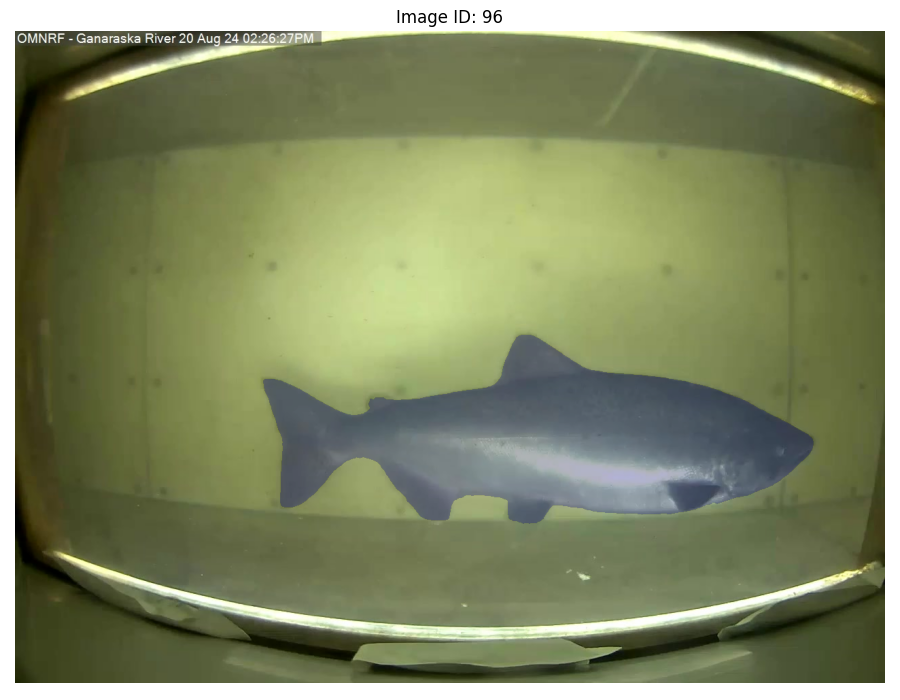

In [28]:
from labelling_functions import MaskEditor
widget = MaskEditor(coco_json_path=json_path, frames_dir=images_path, start_frame=95)

### Extra Code/Testing Area (ignore)

In [43]:
fishway_annotations = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data"
output_ytvis_path = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/ytvis_fishway.json"
labelling_functions.convert_all_coco_to_ytvis(fishway_annotations, output_ytvis_path)

YTVIS JSON saved to /Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/ytvis_fishway.json


In [27]:
edited_json_path = annotations_path / f"edited_{json_path.name}"
with open(edited_json_path) as f:
    edited_coco = json.load(f)

In [48]:
## Save updated segmentations to new JSON file
updated_json_path = annotations_path / f"updated_{json_path.name}"

with open(updated_json_path, "w") as f:
    json.dump(coco_propagated, f, indent=2)